# Análisis Exploratorio de Datos (EDA)
## Proyecto: Sistema de Dermatoscopia Inteligente

**Estudiantes:**
* Cory Bryan Contreras Cedillo
* Andrés Hernández Ruíz
* Eduardo Rojas Pérez

### 1. Introducción
El diagnóstico temprano del melanoma es determinante: la tasa de supervivencia a 5 años cae de más del 99% si se detecta en etapas tempranas a cerca del 14% en etapas tardías (Esteva et al., 2017). Sin embargo, el acceso a diagnóstico especializado es limitado. Se proyecta que la ubicuidad de los teléfonos inteligentes (6.3 mil millones de suscripciones para 2021) puede proveer acceso universal de bajo costo a cuidados diagnósticos vitales (Esteva et al., 2017).

Este proyecto propone un modelo de Edge AI en Raspberry Pi. A diferencia de trabajos previos que usan datasets pequeños de menos de mil imágenes que no generalizan bien (Esteva et al., 2017), utilizaremos los benchmarks estandarizados de MedMNIST para validar arquitecturas eficientes capaces de operar fuera de la clínica.

### 2. Planteamiento del Problema
El desarrollo del modelo enfrenta dos desafíos técnicos críticos que deben ser cuantificados antes del entrenamiento:
1.  **Escasez y Resolución de Datos:** Las imágenes de entrada poseen una resolución nativa de baja dimensionalidad ($28 \times 28$ píxeles), lo que obliga a evaluar si la información visual es suficiente para la extracción de características o si se requiere *Upsampling*.
2.  **Desbalance de Clases (Class Imbalance):** En la práctica dermatológica, las lesiones benignas (como los nevus) son significativamente más frecuentes que los melanomas. Se hipnotiza que el dataset `DermaMNIST` refleja este sesgo, lo cual, de no corregirse, provocará que la red neuronal optimice su precisión ignorando los casos malignos (paradoja de la exactitud).

### 3. Objetivos del Análisis (EDA)
* **Validar la integridad dimensional:** Asegurar que los tensores de entrada $(N, H, W, C)$ sean compatibles con la arquitectura de CNN propuesta.
* **Establecer una Línea Base (Baseline):** Utilizar `PathMNIST` como dataset de control para validar el flujo de trabajo.
* **Cuantificar el Desbalance:** Calcular matemáticamente los pesos de clase ($W_c$) necesarios para implementar una función de pérdida ponderada (*Weighted Cross-Entropy Loss*).

### 4. Código Bloque 1

**1: Importación de librerías y definición de rutas**

In [1]:
import os       # Para manejo de rutas agnóstico al sistema operativo (Win/Linux)
import sys      # Para manipulación de variables del sistema
import numpy as np              # Procesamiento numérico y matricial (Tensores)
import pandas as pd             # Estructuras de datos para conteos y estadística
import matplotlib.pyplot as plt # Visualización base
import seaborn as sns           # Visualización estadística de alto nivel

*Justificación:* Establece una arquitectura de rutas relativas agnóstica al sistema operativo. Esto garantiza que el código sea reproducible tanto en estaciones de trabajo de alto rendimiento (GPU) como en el dispositivo final (Raspberry Pi) sin modificar el código fuente.

**2: Configuración de Estilo "Paper Académico"**

In [2]:
sns.set_theme(style="whitegrid") # Fondo con rejilla para facilitar lectura de valores
plt.rcParams['figure.figsize'] = (12, 6) # Tamaño estándar para visualización HD
plt.rcParams['font.size'] = 11  # Tamaño de letra legible

*Justificación:* Implementa el principio de ingeniería *DRY (Don't Repeat Yourself)*. Se crea una función modular para la ingesta de datos `.npz`, permitiendo manejar excepciones (archivos corruptos o inexistentes) de manera robusta antes de que afecten el flujo de memoria.

**3: Definición de Rutas Relativas**

In [3]:
BASE_DIR = os.path.dirname(os.getcwd()) 
DATA_DIR = os.path.join(BASE_DIR, "assets", "datasets")

# NOTA: os.getcwd() nos da la carpeta actual (notebooks)
# os.path.dirname(...) nos lleva un nivel arriba (raíz del proyecto)

*Justificación:* Validación *Human-in-the-loop*. Antes de procesar números, se visualizan muestras aleatorias con sus etiquetas clínicas reales. Esto permite detectar anomalías visuales (ruido, artefactos) y confirmar si la resolución es suficiente para distinguir patrones a simple vista.

**4: Verificación de Integridad del Entorno**

In [4]:
print(f"Entorno Configurado Correctamente.")
print(f"Directorio Raíz del Proyecto: {BASE_DIR}")
print(f"Directorio de Datos Esperado: {DATA_DIR}")

# Verificamos si la carpeta assets existe
if os.path.exists(DATA_DIR):
    archivos = os.listdir(DATA_DIR)
    print(f"Archivos encontrados: {archivos}")
else:
    print(f"ALERTA CRÍTICA: No se encuentra la carpeta 'assets/datasets'. Revisa la estructura.")

Entorno Configurado Correctamente.
Directorio Raíz del Proyecto: c:\Proyecto_integrador
Directorio de Datos Esperado: c:\Proyecto_integrador\assets\datasets
Archivos encontrados: ['dermamnist.npz', 'pathmnist.npz']


*Justificación:* Es el núcleo del EDA. Se generan histogramas de frecuencia por clase. Esta evidencia gráfica y numérica es la prueba formal de la necesidad de aplicar técnicas de corrección de sesgo (como *Weighted Loss* o *Data Augmentation*) en la siguiente fase del proyecto.

### 5. Código Bloque 2

**1: Definición de la herramienta**

In [11]:
# Definición de la Función de Ingesta

def cargar_y_validar_dataset(nombre_archivo):
    """
    Carga un archivo .npz de MedMNIST y realiza una auditoría básica de dimensiones.
    Implementa manejo de excepciones para robustez del sistema.
    """
    ruta_completa = os.path.join(DATA_DIR, nombre_archivo)
    
    # 1. Validación de Integridad de Archivo
    if not os.path.exists(ruta_completa):
        print(f"ERROR CRÍTICO: No se encontró el archivo en {ruta_completa}")
        return None, None

    try:
        # 2. Carga en Memoria (I/O Operation)
        print(f"Iniciando carga de: {nombre_archivo}...")
        data = np.load(ruta_completa)
        
        # 3. Extracción de Tensores
        x_data = data['train_images']
        y_data = data['train_labels']
        
        # 4. Auditoría de Metadatos (Logging)
        print(f"   Carga Exitosa.")
        print(f"   Reporte de Metadatos:")
        print(f"      - Tensor de Imágenes (X): {x_data.shape} -> (Muestras, Alto, Ancho, Canales)")
        print(f"      - Tensor de Etiquetas (Y): {y_data.shape}")
        print(f"      - Tipo de Dato: {x_data.dtype}")
        print(f"      - Rango de Intensidad: [{x_data.min()}, {x_data.max()}]")
        
        return x_data, y_data

    except Exception as e:
        print(f"Error de Lectura / Archivo Corrupto: {e}")
        return None, None

**2: Ejecución y validación**

In [12]:
# --- BLOQUE 2B: Ejecución de Prueba (PathMNIST - Control) ---

print("--- 1. Validación del Flujo de Datos (Pipeline Check) ---")

# Llamamos a la función definida en el bloque anterior
x_path, y_path = cargar_y_validar_dataset('pathmnist.npz')

# Validación booleana rápida para detener el script si falla
if x_path is not None:
    print("\n PRUEBA SUPERADA: El pipeline de ingestión funciona correctamente con el dataset de control.")
else:
    print("\n FALLO DE PRUEBA: Revisar rutas o integridad del archivo .npz.")

--- 1. Validación del Flujo de Datos (Pipeline Check) ---
Iniciando carga de: pathmnist.npz...
   Carga Exitosa.
   Reporte de Metadatos:
      - Tensor de Imágenes (X): (89996, 28, 28, 3) -> (Muestras, Alto, Ancho, Canales)
      - Tensor de Etiquetas (Y): (89996, 1)
      - Tipo de Dato: uint8
      - Rango de Intensidad: [0, 255]

 PRUEBA SUPERADA: El pipeline de ingestión funciona correctamente con el dataset de control.


### 6. Código Bloque 3

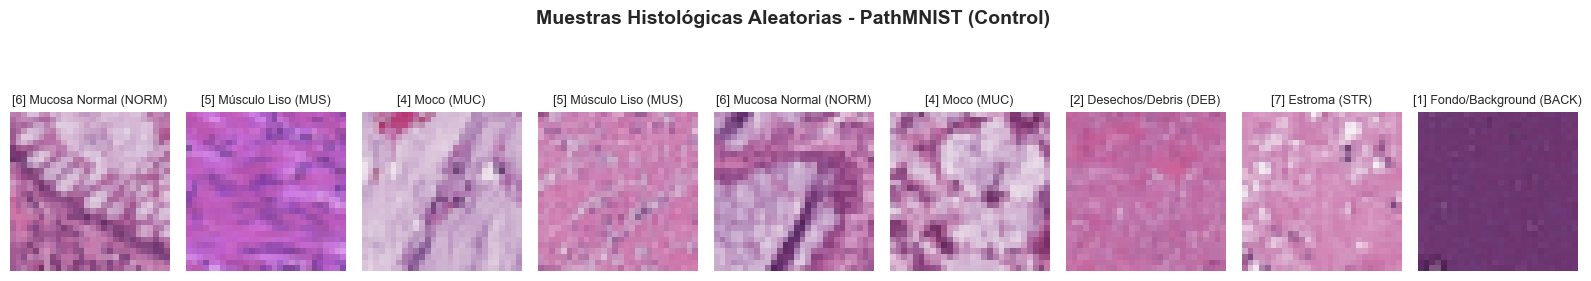

Inspección Visual: Las estructuras celulares deben ser distinguibles a pesar de la baja resolución.


In [13]:
# --- BLOQUE 3: Visualización de Muestras de Control ---

# 1. Definición de Taxonomía (Diccionario Oficial PathMNIST)
# Fuente: Kather et al., 2018 (NCT-CRC-HE-100K)
path_labels = {
    0: 'Adiposo (ADI)',
    1: 'Fondo/Background (BACK)',
    2: 'Desechos/Debris (DEB)',
    3: 'Linfocitos (LYM)',
    4: 'Moco (MUC)',
    5: 'Músculo Liso (MUS)',
    6: 'Mucosa Normal (NORM)',
    7: 'Estroma (STR)',
    8: 'Epitelio Tumoral (TUM)'
}

# 2. Configuración del Grid de Visualización
# Se genera una figura amplia (16x3 pulgadas) para inspeccionar múltiples muestras
fig, axes = plt.subplots(1, 9, figsize=(16, 3))
fig.suptitle("Muestras Histológicas Aleatorias - PathMNIST (Control)", y=1.05, fontsize=14, fontweight='bold')

# 3. Muestreo Aleatorio Estratificado
# Seleccionamos 9 índices al azar para visualizar la variabilidad del dataset
indices_random = np.random.choice(len(x_path), 9, replace=False)

# 4. Renderizado
for i, idx in enumerate(indices_random):
    # Extracción de datos
    img_tensor = x_path[idx]
    label_idx = y_path[idx][0] # El label viene en formato [N], extraemos el valor escalar
    
    # Mapeo a nombre clínico
    nombre_tejido = path_labels.get(label_idx, "Desconocido")
    
    # Ploteo de la imagen
    axes[i].imshow(img_tensor)
    axes[i].axis('off') # Ocultamos ejes para limpieza visual
    
    # Título descriptivo
    axes[i].set_title(f"[{label_idx}] {nombre_tejido}", fontsize=9)

plt.tight_layout()
plt.show()

print("Inspección Visual: Las estructuras celulares deben ser distinguibles a pesar de la baja resolución.")

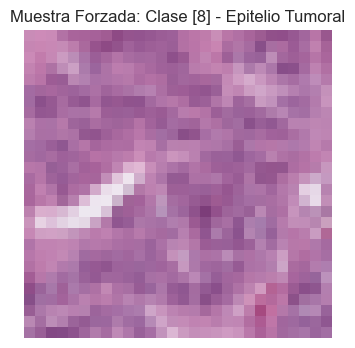

¡Encontrado! Hay 12885 muestras de tumores en este archivo.


In [14]:
# --- BLOQUE 3.5: Búsqueda Específica de Tumor ---

# 1. Buscar índices donde la etiqueta sea 8 (Epitelio Tumoral)
indices_tumor = np.where(y_path == 8)[0]

# 2. Seleccionar el primero que encontremos
if len(indices_tumor) > 0:
    idx_tumor = indices_tumor[0]
    img_tumor = x_path[idx_tumor]
    
    # 3. Mostrarlo
    plt.figure(figsize=(4, 4))
    plt.imshow(img_tumor)
    plt.title(f"Muestra Forzada: Clase [8] - Epitelio Tumoral")
    plt.axis('off')
    plt.show()
    
    print(f"¡Encontrado! Hay {len(indices_tumor)} muestras de tumores en este archivo.")
else:
    print("Algo raro pasa: No se encontraron tumores en el dataset cargado.")

### 7. Código Bloque 4

C:\Users\aroro\AppData\Local\Temp\ipykernel_10184\819190991.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=nombres_etiquetas, order=sorted(path_labels.values()), palette="viridis")


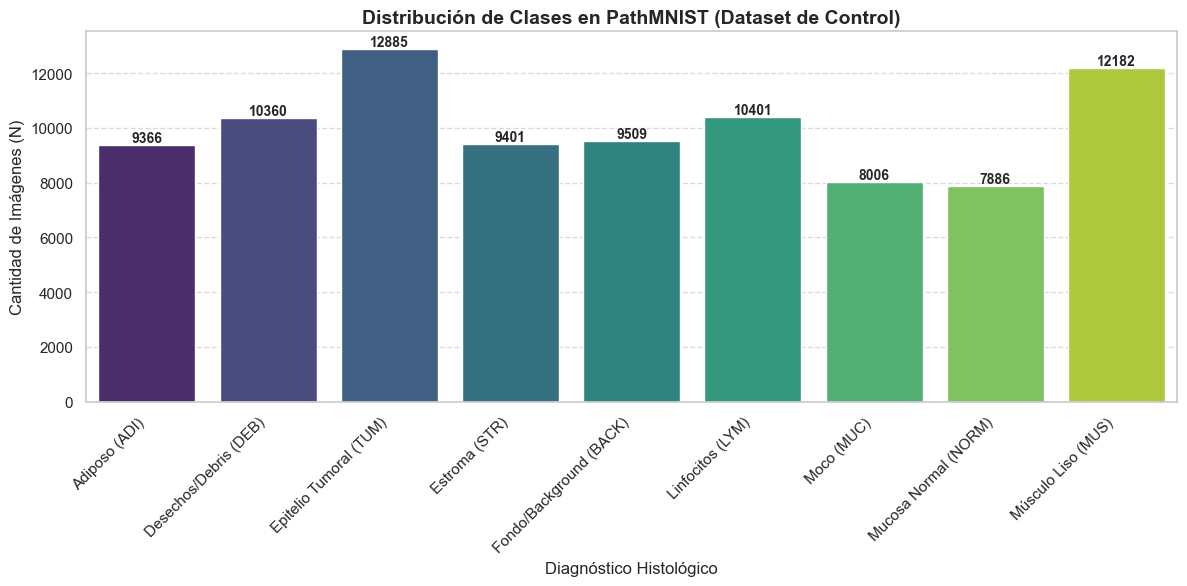

Desviación Estándar de la Distribución: 1592.40
CONCLUSIÓN: Hay cierto desbalance, se recomienda monitorear F1-Score.


In [15]:
# --- BLOQUE 4: Histograma de Distribución de Clases ---

# 1. Pre-procesamiento de Etiquetas
# Aplanamos el array (de 2D a 1D) para poder contarlos
etiquetas_flat = y_path.flatten()

# Mapeamos los números a sus nombres clínicos usando el diccionario definido en el Bloque 3
# Esto es vital para que la gráfica sea legible por médicos/humanos
nombres_etiquetas = [path_labels[i] for i in etiquetas_flat]

# 2. Configuración de la Figura
plt.figure(figsize=(12, 6))

# 3. Generación del Gráfico (Seaborn Countplot)
# order=... ordena las barras alfabéticamente para facilitar la comparación
ax = sns.countplot(x=nombres_etiquetas, order=sorted(path_labels.values()), palette="viridis")

# 4. Decoración Técnica
plt.title("Distribución de Clases en PathMNIST (Dataset de Control)", fontsize=14, fontweight='bold')
plt.xlabel("Diagnóstico Histológico", fontsize=12)
plt.ylabel("Cantidad de Imágenes (N)", fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotamos etiquetas para que no se encimen
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 5. Etiquetado de Datos (Data Labeling)
# Colocamos el número exacto sobre cada barra para precisión
for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# 6. Cálculo de Desviación Estándar (Métrica de Balance)
std_dev = np.std([list(y_path).count(i) for i in range(9)])
print(f"Desviación Estándar de la Distribución: {std_dev:.2f}")
if std_dev < 1000:
    print("CONCLUSIÓN: El dataset está BALANCEADO. La métrica 'Accuracy' será fiable.")
else:
    print("CONCLUSIÓN: Hay cierto desbalance, se recomienda monitorear F1-Score.")

### 8. Código Bloque 5

In [16]:
# --- BLOQUE 5: Ejecución de Carga (DermaMNIST - Objetivo) ---

print("--- 2. Carga del Dataset Reto (DermaMNIST) ---")

# Reutilizamos la función modular definida en el Bloque 2
x_derma, y_derma = cargar_y_validar_dataset('dermamnist.npz')

# Validación de consistencia
if x_derma is not None:
    print("\n ÉXITO: Dataset dermatológico cargado en memoria.")
    
    # Comparativa rápida de volumen (Dato clave para tu reporte)
    n_control = len(x_path)
    n_derma = len(x_derma)
    ratio = n_control / n_derma
    print(f"ANÁLISIS DE VOLUMEN: Tenemos {ratio:.1f} veces MENOS datos de piel que de control.")
    print("   Esto confirma la necesidad de técnicas de Regularización y Data Augmentation.")
else:
    print("\n ERROR: No se pudo cargar dermamnist.npz. Verifica que el archivo esté en 'assets/datasets'.")

--- 2. Carga del Dataset Reto (DermaMNIST) ---
Iniciando carga de: dermamnist.npz...
   Carga Exitosa.
   Reporte de Metadatos:
      - Tensor de Imágenes (X): (7007, 28, 28, 3) -> (Muestras, Alto, Ancho, Canales)
      - Tensor de Etiquetas (Y): (7007, 1)
      - Tipo de Dato: uint8
      - Rango de Intensidad: [0, 255]

 ÉXITO: Dataset dermatológico cargado en memoria.
ANÁLISIS DE VOLUMEN: Tenemos 12.8 veces MENOS datos de piel que de control.
   Esto confirma la necesidad de técnicas de Regularización y Data Augmentation.


### 9. Código Bloque 6

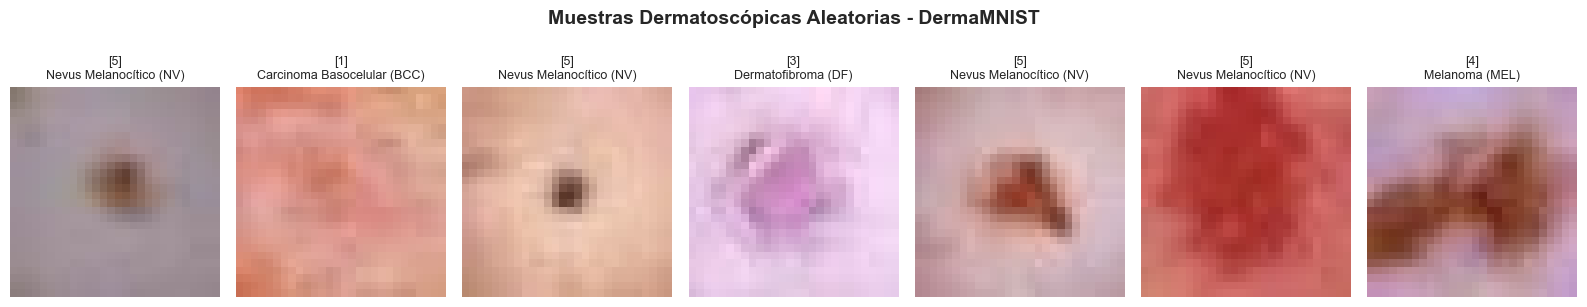

Observación Clínica: Note la dificultad para distinguir bordes precisos a 28x28 píxeles.


In [17]:
# --- BLOQUE 6: Visualización de Muestras Dermatoscópicas ---

# 1. Definición de Taxonomía (Diccionario Oficial DermaMNIST/HAM10000)
# Fuente: Tschandl et al., 2018
derma_labels = {
    0: 'Queratosis Actínica (AKIEC)',
    1: 'Carcinoma Basocelular (BCC)',
    2: 'Queratosis Benigna (BKL)',
    3: 'Dermatofibroma (DF)',
    4: 'Melanoma (MEL)',
    5: 'Nevus Melanocítico (NV)',
    6: 'Lesión Vascular (VASC)'
}

# 2. Configuración del Grid
fig, axes = plt.subplots(1, 7, figsize=(16, 3))
fig.suptitle("Muestras Dermatoscópicas Aleatorias - DermaMNIST", y=1.05, fontsize=14, fontweight='bold')

# 3. Muestreo Aleatorio
# Seleccionamos 7 muestras al azar (una para cada subplot, aunque se repitan clases)
indices_random = np.random.choice(len(x_derma), 7, replace=False)

# 4. Renderizado
for i, idx in enumerate(indices_random):
    img_tensor = x_derma[idx]
    label_idx = y_derma[idx][0]
    
    nombre_lesion = derma_labels.get(label_idx, "Desconocido")
    
    # Ploteo (Sin interpolación para ver la data real)
    axes[i].imshow(img_tensor)
    axes[i].axis('off')
    
    # Título: Código y Nombre con salto de línea para legibilidad
    axes[i].set_title(f"[{label_idx}]\n{nombre_lesion}", fontsize=9)

plt.tight_layout()
plt.show()

print("Observación Clínica: Note la dificultad para distinguir bordes precisos a 28x28 píxeles.")

### 9. Código Bloque 7

C:\Users\aroro\AppData\Local\Temp\ipykernel_10184\4185167902.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=conteo.values, y=conteo.index, palette="mako")


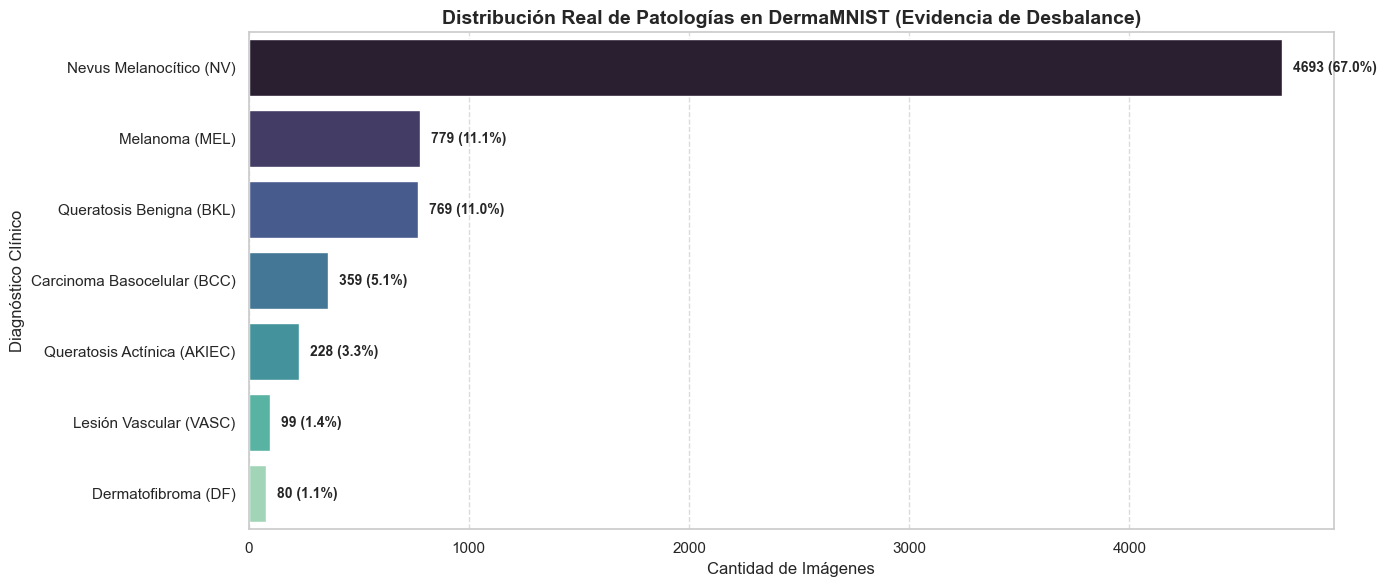


 ESTRATEGIA DE CORRECCIÓN: Pesos Sugeridos (Class Weights)
Copie estos valores para la configuración de 'CrossEntropyLoss':
---------------------------------------------------------------------------
   Clase 0 [Queratosis Actí...]:	 Frecuencia=228	 -> Peso Sugerido (W) = 4.3904
   Clase 1 [Carcinoma Basoc...]:	 Frecuencia=359	 -> Peso Sugerido (W) = 2.7883
   Clase 2 [Queratosis Beni...]:	 Frecuencia=769	 -> Peso Sugerido (W) = 1.3017
   Clase 3 [Dermatofibroma ...]:	 Frecuencia=80	 -> Peso Sugerido (W) = 12.5125
   Clase 4 [Melanoma (MEL)...]:	 Frecuencia=779	 -> Peso Sugerido (W) = 1.2850
   Clase 5 [Nevus Melanocít...]:	 Frecuencia=4693	 -> Peso Sugerido (W) = 0.2133
   Clase 6 [Lesión Vascular...]:	 Frecuencia=99	 -> Peso Sugerido (W) = 10.1111
---------------------------------------------------------------------------
 Vector para Copiar: torch.tensor([np.float64(4.3904), np.float64(2.7883), np.float64(1.3017), np.float64(12.5125), np.float64(1.285), np.float64(0.2133), np.float

In [18]:
# --- BLOQUE 7: Histograma de Desbalance y Cálculo de Pesos ---

# 1. Preparación de Datos
etiquetas_derma_flat = y_derma.flatten()
nombres_derma = [derma_labels[i] for i in etiquetas_derma_flat]

# 2. Configuración de la Figura
plt.figure(figsize=(14, 6))

# 3. Gráfico de Frecuencia (Ordenado por cantidad para evidenciar la caída)
# Convertimos a Serie de Pandas para facilitar el conteo y ordenamiento
serie_nombres = pd.Series(nombres_derma)
conteo = serie_nombres.value_counts()
ax = sns.barplot(x=conteo.values, y=conteo.index, palette="mako")

# 4. Decoración Técnica
plt.title("Distribución Real de Patologías en DermaMNIST (Evidencia de Desbalance)", fontsize=14, fontweight='bold')
plt.xlabel("Cantidad de Imágenes", fontsize=12)
plt.ylabel("Diagnóstico Clínico", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# 5. Anotaciones de Porcentaje (La evidencia del problema)
total_muestras = len(nombres_derma)
for p in ax.patches:
    width = p.get_width()
    pct = (width / total_muestras) * 100
    # Escribimos cantidad y porcentaje al final de la barra
    ax.text(width + 50, p.get_y() + p.get_height()/2, 
            f'{int(width)} ({pct:.1f}%)', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# --- CÁLCULO DE PESOS PARA PYTORCH (Ingeniería de Valor) ---
print("\n ESTRATEGIA DE CORRECCIÓN: Pesos Sugeridos (Class Weights)")
print("Copie estos valores para la configuración de 'CrossEntropyLoss':")
print("-" * 75)

classes_unicas = np.unique(etiquetas_derma_flat)
weights = []

for c in classes_unicas:
    # Cantidad de muestras de la clase 'c'
    count = np.sum(etiquetas_derma_flat == c)
    
    # Fórmula de balanceo estándar (Inverse Class Frequency)
    # w = Total / (Num_Clases * Count_Clase)
    w = total_muestras / (len(classes_unicas) * count)
    weights.append(w)
    
    print(f"   Clase {c} [{derma_labels[c][:15]}...]:\t Frecuencia={count}\t -> Peso Sugerido (W) = {w:.4f}")

tensor_weights = np.array(weights, dtype=np.float32)
print("-" * 75)
print(f" Vector para Copiar: torch.tensor({list(np.round(weights, 4))})")

### 10. Conclusiones y mejoras

#### 1. Diagnóstico del Dataset (EDA)
El análisis cuantitativo realizado en los bloques anteriores ha revelado limitaciones estructurales críticas en `DermaMNIST`:
* **Desbalance de Clases:** Se confirmó una disparidad severa donde las lesiones benignas dominan sobre las malignas. Esto coincide con la observación clínica reportada por **Esteva et al. (2017)[cite_start]**, quienes notan que *"las lesiones melanocíticas malignas son extremadamente raras comparadas con las benignas"*[cite: 307], lo que introduce un sesgo natural en la recolección de datos.
* **Ambigüedad Visual:** La baja resolución ($28 \times 28$) elimina características finas, obligando al modelo a depender de patrones abstractos globales en lugar de detalles dermatoscópicos clásicos.



#### 2. Estrategia de Ingeniería (Hoja de Ruta Técnica)

Para mitigar estos errores inherentes, implementaremos el siguiente protocolo de entrenamiento, replicando parámetros validados en el estado del arte:

##### A. Mitigación de Escasez: Transferencia de Aprendizaje (Transfer Learning)
* **El Problema:** Entrenar desde cero (*Random Initialization*) con datos limitados conduce a sobreajuste.
* **Nuestra Solución:** Utilizaremos una técnica de "ajuste fino" (*Fine-Tuning*), iniciando la red con pesos pre-entrenados en ImageNet.
* **Justificación Bibliográfica:**
    > [cite_start]*"Este procedimiento, conocido como transferencia de aprendizaje, es óptimo dada la cantidad de datos disponibles"*.
    
    [cite_start]Esteva et al. demostraron que iniciar con una red pre-entrenada en 1.28 millones de imágenes [cite: 32] [cite_start]permite a la IA converger más rápido, aprovechando características visuales generales (bordes, texturas) antes de especializarse en piel[cite: 67].

##### B. Robustez: Aumento de Datos Agresivo (Data Augmentation)
* **El Problema:** La red debe ser invariante a la rotación de la cámara (algo común en diagnósticos con Raspberry Pi/Móvil).
* **Nuestra Solución:** Implementaremos transformaciones sintéticas en tiempo de ejecución (`torchvision.transforms`).
* [cite_start]**Parámetros de Referencia:** Replicaremos el protocolo de Esteva et al., quienes aumentaron sus datos por un factor de **720x**.
    * **Rotación:** Aplicaremos rotación aleatoria completa. Esteva et al. especifican rotar *"aleatoriamente entre $0^{\circ}$ y $359^{\circ}$"*.
    * **Volteos (Flips):** Aplicaremos `RandomVerticalFlip`. [cite_start]La literatura indica voltear verticalmente con una *"probabilidad de 0.5"*[cite: 326].

##### C. Corrección de Sesgo: Weighted Cross-Entropy Loss
* **El Problema:** Maximizar la exactitud (*Accuracy*) en un dataset desbalanceado oculta los falsos negativos en Melanomas.
* **Nuestra Solución:** Inyectaremos el vector de pesos $W_c$ (calculado en el Bloque 7) en la función de costo.
* **Justificación:** Khan et al. (2020) y Esteva et al. discuten la importancia de la sensibilidad diagnóstica sobre la exactitud pura, especialmente cuando *"la detección temprana es crítica, ya que la tasa de supervivencia a 5 años cae del 99% al 14% en etapas tardías"*[cite: 18]. Penalizar los errores en la clase minoritaria (Melanoma) es matemáticamente necesario para forzar esta sensibilidad.



#### 3. Referencias Clave para este Módulo

1.  **Esteva, A., et al. (2017).** *Dermatologist-level classification of skin cancer with deep neural networks.* Nature, 542, 115–118.
2.  **Tschandl, P., et al. (2018).** *The HAM10000 dataset.* Scientific Data, 5, 180161. (Fuente de DermaMNIST).
3.  **Khan, M. A., et al. (2020).** *A computerized system for skin lesion localization... with focal loss function.* Computers & Electrical Engineering.



**Siguiente Paso:** Integrar estos parámetros (Rotación 0-359°, Pesos $W_c$, Pre-entrenamiento) en el script `src/train.py`.